In [ ]:
import numpy as np
import pandas as pd
from openai import OpenAI
from datetime import datetime
from pathlib import Path
from typing import List
import re
from dotenv import load_dotenv
import os
from pydantic import BaseModel
import json
import matplotlib.pyplot as plt

## Helper Functions

In [ ]:
def save_df_to_csv(samples_df: pd.DataFrame, name: str = 'samples', directory: str = './data/'):
    timestamp_str = datetime.now().strftime("%Y%m%d%H%M%S")
    samples_df.to_csv(f"{directory}{name}_{timestamp_str}.csv")

In [ ]:
def list_files(directory: str) -> List[str]:
    """Return all file names (not directories) in the given directory."""
    path = Path(directory).expanduser()
    return [p.name for p in path.iterdir() if p.is_file()]

In [ ]:
def get_last_saved_timestamp(directory: str = './data/'):
    filenames = list_files(directory)
    matches = [ re.search(r'.*?(\d{14})\.csv$', fn) for fn in filenames ]
    timestamps = [ int(m.group(1)) for m in matches if m is not None ]
    return str(max(timestamps))

# get_last_saved_timestamp()

In [ ]:
def load_df(timestamp: str, name: str = 'samples', directory: str = './data/') -> pd.DataFrame:
    return pd.read_csv(f"{directory}{name}_{timestamp}.csv", index_col=0)

In [ ]:
def load_latest_df(name: str = 'samples', directory: str = './data/') -> pd.DataFrame:
    timestamp = get_last_saved_timestamp(directory=directory)
    return load_df(timestamp=timestamp, name=name, directory=directory)

## Do Stuff

In [ ]:
# read in env vars from the .env file
load_dotenv(override=True)

PROMPT_ID_SYNTH_GEN = os.environ['PROMPT_ID_SYNTH_GEN']
PROMPT_ID_SUFFIX_LIST = ['SMALL', 'MEDIUM', 'LARGE']

# connect and get an OpenAI client
client = OpenAI()

In [ ]:
class BioSnippet(BaseModel):
    text_snippet: str
    source: str
    is_match: bool

In [ ]:
class UserWithLabeledSnippets(BaseModel):
    first_name: str
    last_name: str
    city: str
    state: str
    birth_year: int
    snippets: list[BioSnippet]

In [ ]:
class ListOfUsersWithLabeledSnippets(BaseModel):
    users: list[UserWithLabeledSnippets]

In [ ]:
def generate_synthetic_samples(prompt_id, n_people=10) -> pd.DataFrame:
    resp = client.responses.parse(
        prompt={"id": prompt_id},
        input=[
            {
                "role": "user",
                "content": f"""
                    Generate {n_people} example fictional people. 
                    - Each person should have 5 to 10 snippets. 
                    - Each snippet should represent a brief bio of the fictional person found via googling. e.g. a whitepages.com listing, an instagram bio, a reddit post, etc.
                    - Each snippet should either actually match the person, and hence have a label of is_match=True, or it should be a close, but not actual, match, and have is_match=False.
                    - About half of the snippets per person should be true matches, and half should be false.
                    - Each snippet should have a source (e.g. whitepages, reddit, instagram)
                """,
            },
        ],
        text_format=ListOfUsersWithLabeledSnippets,
    )   
    users_list = json.loads(resp.output_text)['users']

    samples_df = pd.DataFrame(columns=['First Name', 'Last Name', 'City', 'State', 'Birth Year', 'Text Snippet', 'Source', 'Is Match'])
    for user in users_list:
        for snippet in user['snippets']:
            new_row = {
                "First Name": user['first_name'],
                "Last Name": user['last_name'],
                "City": user['city'],
                "State": user['state'],
                "Birth Year": user['birth_year'],
                "Text Snippet": snippet['text_snippet'],
                "Source": snippet['source'],
                "Is Match": snippet['is_match'],
            }
            samples_df = pd.concat([samples_df, pd.DataFrame([new_row])], ignore_index=True)

    save_df_to_csv(samples_df)

    return samples_df


In [153]:
# samples_df = generate_synthetic_samples(os.environ['PROMPT_ID_SYNTH_GEN'], n_people=10)

In [ ]:
class MatchScoreResponse(BaseModel):
    match_prob: float

In [186]:
class MatchScoreResponseWithReason(MatchScoreResponse):
    reason: str

In [190]:
def construct_match_prob_prompt(first_name, last_name, city, state, birth_year, snippet, source, include_reason=False):
    prompt = f"""
        Here is the profile of a person. (The current year is 2025). 
        - First Name: {first_name}
        - Last Name: {last_name}
        - City: {city}
        - State: {state}
        - Birth Year: {birth_year}
        Here is a snippet found online via googling that person: "{snippet}"

        It is from {source}.

        Please output the probability (a number from 0 to 1 rounded to two decimal places) that the snippet is 
        referring to that specific person. 1 means you are absolutely sure that it is a match, and 0 means that you
        are absolutely sure it is not.
    """

    if include_reason:
        prompt += "\n\nInclude your your reasoning for the score you gave, in one or two sentences."

    return prompt


In [193]:
def get_match_prob(row, prompt_id_suffix, include_reason=False):
    first_name = row['First Name']
    last_name = row['Last Name']
    city = row['City']
    state = row['State']
    birth_year = row['Birth Year']
    snippet = row['Text Snippet']
    source = row['Source']

    input_message = construct_match_prob_prompt(first_name, last_name, city, state, birth_year, snippet, source, include_reason)

    text_format = MatchScoreResponseWithReason if include_reason else MatchScoreResponse

    resp = client.responses.parse(
        prompt={"id": os.environ[f"PROMPT_ID_SCORER_{prompt_id_suffix}"]},
        input=[
            {
                "role": "user",
                "content": input_message
            },
        ],
        text_format=text_format,
    )   

    if include_reason:
        return (float(json.loads(resp.output_text)['match_prob']), json.loads(resp.output_text)['reason'])
    else:
        return (float(json.loads(resp.output_text)['match_prob']), None)

In [ ]:
def get_all_match_probs(df, prompt_id_suffix):
    match_probs_list = []
    for _, row in df.iterrows():
        match_prob = get_match_prob(row, prompt_id_suffix)
        match_probs_list.append(match_prob)
    
    df[f"Match Prob {prompt_id_suffix}"] = pd.Series(match_probs_list, index=df.index)

In [ ]:
def run_all_prompt_scorers(df):
    for prompt_id_suffix in PROMPT_ID_SUFFIX_LIST:
        get_all_match_probs(df, prompt_id_suffix=prompt_id_suffix)

In [156]:
# run_all_prompt_scorers(samples_df)
samples_df = load_latest_df()

In [157]:
samples_df[['Is Match', 'Match Prob SMALL', 'Match Prob MEDIUM', 'Match Prob LARGE']].head()

,Is Match,Match Prob SMALL,Match Prob MEDIUM,Match Prob LARGE
0,True,0.92,0.92,0.88
1,True,0.97,0.99,0.95
2,True,0.00,0.68,0.18
3,False,0.03,0.02,0.02
4,False,0.20,0.60,0.57


## Analyze the Results

In [ ]:
cols = ["Match Prob SMALL", "Match Prob MEDIUM", "Match Prob LARGE"]
df_true = samples_df[samples_df["Is Match"] == True]
df_false = samples_df[samples_df["Is Match"] == False]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10), sharex=False)
for ax, col in zip(axes, cols):
    bins = np.linspace(0.0, 1.0, 21)  # 20 bins
    ax.hist(df_true.loc[df_true[col] >= 0.0, col], bins=bins, alpha=0.6, label="Is Match = True", color="tab:blue")
    ax.hist(df_false.loc[df_false[col] >= 0.0, col], bins=bins, alpha=0.6, label="Is Match = False", color="tab:orange")
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.legend()

axes[-1].set_xlabel("Probability")
fig.tight_layout()
plt.show()

In [ ]:
for prompt_id_suffix in PROMPT_ID_SUFFIX_LIST:
    col = f"Match Prob {prompt_id_suffix}"
    probs_true = samples_df.loc[samples_df['Is Match'], col]
    probs_false = samples_df.loc[~(samples_df['Is Match'].astype(bool)), col]
    
    print(f"Using {prompt_id_suffix} Model:")
    print(f"True Matches:\t{probs_true.mean():.2f}")
    print(f"False Matches:\t{probs_false.mean():.2f}\n")


In [ ]:
def get_accuracy(df, prompt_id_suffix, thresh: float = 0.5) -> float:
    predictions = df[f"Match Prob {prompt_id_suffix}"] > thresh
    print(f"{prompt_id_suffix}: ")
    print(f"Total observations:\t{len(df)}")
    print(f"True match count:\t{df['Is Match'].sum()}")
    print(f"Predicted true matches:\t{predictions.sum()}")
    print(f"Correct predcitions:\t{(predictions == df['Is Match']).sum()}\n")

In [ ]:
_ = [ get_accuracy(samples_df, prompt_id_suffix) for prompt_id_suffix in PROMPT_ID_SUFFIX_LIST ]

In [ ]:
def bce_loss(df, prompt_id_suffix) -> float:
    epsilon = 1e-6
    y = df['Is Match'].astype(float)
    probs = np.clip(df[f"Match Prob {prompt_id_suffix}"], epsilon, 1-epsilon)
    loss = (y * np.log(probs) + (1 - y) * np.log(1 - probs)).sum()
    return loss

In [ ]:
def calc_and_print_bce_loss(df, prompt_id_suffix):
    loss = bce_loss(df, prompt_id_suffix)
    print(f"{prompt_id_suffix} BCE Loss: \t{loss:.1f}")

In [ ]:
_ = [ calc_and_print_bce_loss(samples_df, prompt_id_suffix) for prompt_id_suffix in PROMPT_ID_SUFFIX_LIST ]

## Investigate the Weirdness

In [ ]:
# find examples from large model that are really wrong and investigate

# subset to y=True, find lowest prob
example_row = samples_df[samples_df['Is Match']].sort_values('Match Prob LARGE').iloc[0]
print(f"{example_row['First Name']} {example_row['Last Name']}; {example_row['City']}, {example_row['State']}; b. {example_row['Birth Year']}")
print(example_row['Text Snippet'])

Priya Narayanan; Edison, New Jersey; b. 1994
Priya Narayanan is a data analyst based in Edison, NJ, focusing on healthcare analytics and population health dashboards.


In [195]:
example_match_prob, example_reason = get_match_prob(example_row, "LARGE", include_reason=True)

In [ ]:
# run this 100 times and plot the distribution
match_prob_list = []
for i in range(100):
    match_prob_list.append(get_match_prob(example_row, "LARGE", include_reason=True))

In [ ]:
example_df = pd.DataFrame(match_prob_list, columns=['Match Prob', 'Reason'])
example_df

In [ ]:
match_prob_array = np.array(match_prob_list)
print(f"Mean: {match_prob_array.mean()}; Std Dev: {match_prob_array.std()}")

(array([10.,  0.,  1.,  0.,  2.,  1.,  4., 17., 30., 35.]),
 array([0.   , 0.093, 0.186, 0.279, 0.372, 0.465, 0.558, 0.651, 0.744,
        0.837, 0.93 ]),
 <BarContainer object of 10 artists>)

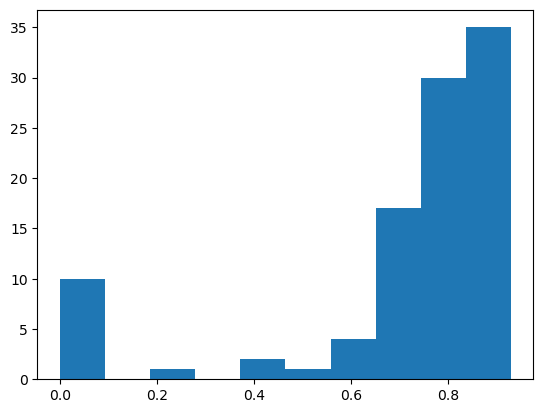

In [184]:
plt.hist(match_prob_array)